In [1]:
# Differential abundance plots comparing alga present, algal spent medium, and no alga control conditions
#
# Author: Vanessa Brisson
# Copyright (C) 2023 Vanessa Brisson
#
# License: MIT

In [2]:
# LOAD NECESSARY PACKAGES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chisquare
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import linregress
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle


In [3]:
# LOAD THE DATA

# this is the differential abundance data generated in the ANCOMBC analysis 
# of the no metabolite addition experiment

data = pd.read_csv('ProcessedSequencingData/DA_Ctrl_with_labels.csv', index_col=0)
data = data.rename(columns={"rowMeans(otu_table(ps.ABC.RA))": "mean"})
data["PStoP"].fillna(False,inplace=True)
data["PtoC"].fillna(False,inplace=True)
data["PStoC"].fillna(False,inplace=True)
data["LFC.PStoP"].fillna(0,inplace=True)
data["LFC.PtoC"].fillna(0,inplace=True)
data["LFC.PStoC"].fillna(0,inplace=True)
data

,Row.names,PStoP,LFC.PStoP,PtoC,LFC.PtoC,PStoC,LFC.PStoC,means,Kingdom,Phylum,Class,Order,Family,Genus,RDPGenus,Species,Label
ASV1,ASV1,True,-0.858112,True,0.791510,False,-0.040982,0.246405,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Marinobacteraceae,Marinobacter,Marinobacter,ASV1,Marinobacter
ASV10,ASV10,True,-0.369818,True,0.954235,True,0.610037,0.033077,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Seohaeicola,Seohaeicola,ASV10,Seohaeicola
ASV12,ASV12,False,-0.039704,True,-1.377726,True,-1.391810,0.041661,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Hyphomonadaceae,Oceanicaulis,Oceanicaulis,ASV12,Oceanicaulis
ASV13,ASV13,True,-0.129035,True,-0.717853,True,-0.821268,0.036103,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,NaN,NaN,ASV13,[family: Rhodobacteraceae]
ASV14,ASV14,False,-0.055149,True,2.698327,True,2.668798,0.021255,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Alcanivoracaceae1,Alcanivorax,Alcanivorax,ASV14,Alcanivorax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASV71,ASV71,False,0.000000,False,0.000000,False,0.000000,0.000085,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Blautia,Blautia,ASV71,Blautia
ASV74,ASV74,False,0.000000,False,0.000000,False,0.000000,0.000090,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9,Prevotella,ASV74,Prevotella
ASV79,ASV79,False,0.000000,False,0.000000,False,0.000000,0.000069,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Rhodobaculum,Pararhodobacter,ASV79,Pararhodobacter (Rhodobaculum)
ASV8,ASV8,True,1.119229,True,1.016286,True,2.161135,0.035825,Bacteria,Proteobacteria,Gammaproteobacteria,Nitrosococcales,Methylophagaceae,Methylophaga,Methylophaga,ASV8,Methylophaga


In [4]:
# PREPROCESS THE DATA

# subset to ASVs with mean relative abundance > 0.1% 
mydata = data.loc[data['means'] > 0.001]
# sort based on fold change between alga present condition (P) and alga free condition (C)
mydata = mydata.sort_values('LFC.PtoC', ascending=False)

# get log 2 fold change is with respect to alga free condition (C). ANOCOMBC had this reversed for PtoC and PStoC
test = np.vstack((mydata['LFC.PtoC'] *-1* mydata['PtoC'], 
                  mydata['LFC.PStoC']*-1*mydata['PStoC'],
                  mydata['LFC.PStoP']* 1*mydata['PStoP']))
test = test.transpose()
# convert from L22FC to direction of change (+, -, or no sig change)
test = np.where(test<0,-1,test)
test = np.where(test>0,1,test)
test = pd.DataFrame(test)
test.index = mydata.index
test.columns = ['CtoPdir','CtoPSdir','PStoPdir']

# merge L2FC and direction data into ptocessed data
mydata = test.merge(mydata, left_index=True, right_index=True)
mydata.sort_values(['CtoPdir','CtoPSdir'], inplace=True)

labels = [mydata['Label'][str(rn)] + ' ' + rn for rn in  mydata['Row.names']]


In [5]:
# get colors list for data based on taxonomic group
colors = []
for idx in mydata['Row.names']:
    if mydata.loc[idx]['Phylum'] == 'Bacteroidota':
        colors.append('purple')
    elif mydata.loc[idx]['Class'] == 'Alphaproteobacteria':
        colors.append('black')
    elif mydata.loc[idx]['Class'] == 'Gammaproteobacteria':
        colors.append('green')
    else:
        colors.append('grey')

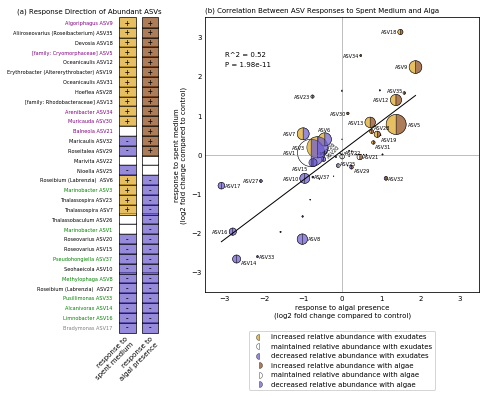

In [6]:
# RELATIVE ABUNDANCE FIGURE

# set up the figure
fig = plt.figure(figsize=(6.88,5.5))
gs = GridSpec(2,2,width_ratios=[1,6], height_ratios=[50,1])
ax2 = fig.add_subplot(gs[0,1])
ax1 = fig.add_subplot(gs[:,0])

# PART A - RESPONSE DIRECTION
plt.sca(ax1)

# plot +- response to algal presence
for y in np.arange(len(mydata.index)):
        if mydata.iloc[y,0] == 1:
            s = ' + '
            fc = 'saddlebrown'
        elif mydata.iloc[y,0] == -1:
            s = ' - '
            fc = 'slateblue'
        else:
            s = '   '
            fc='white'
        plt.text(0.75,y+0.5,s, ha='center',va='center',family='monospace', fontsize=8,
                 bbox=dict(facecolor=fc,pad=1.0,alpha=0.7))  
        
# plot +- response to spent medium
for y in np.arange(len(mydata.index)):
        if mydata.iloc[y,1] == 1:
            s = ' + '
            fc='goldenrod'
        elif mydata.iloc[y,1] == -1:
            s = ' - '
            fc='slateblue'
        else:
            s = '   '
            fc='white'
        plt.text(0.25,y+0.5,s, ha='center',va='center',family='monospace', fontsize=8,
                 bbox=dict(facecolor=fc,pad=1.0,alpha=0.7))
        
# clean up and add labels
plt.ylim(0,mydata.shape[0])
plt.xticks([0.95,0.4],['response to\nalgal presence','response to\nspent medium'], rotation=45, fontsize=7, ha='right')
plt.title('(a) Response Direction of Abundant ASVs',loc='right',va='center', fontsize=7)
plt.yticks(np.arange(len(labels))+0.5,labels, fontsize=5)
ax1.tick_params(length=0)
ax1.yaxis.tick_left()
for idx in range(len(labels)):
    ax1.get_yticklabels()[idx].set_color(colors[idx]) 
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)


# PART B - CORRELATION BETWEEN RESPONSES TO ALGA AND SPENT MEDIUM
plt.sca(ax2)

# plot the scatter points for each ASV
x = list(data['LFC.PtoC']*-1)
y = list(data['LFC.PStoC']*-1)
s = list(np.log(data['means']*100000)*10)
s = list(data['means']*3000)
mycolorsA = ['slateblue' if data['PtoC'][i] and data['LFC.PtoC'][i] > 0
            else 'saddlebrown' if data['PtoC'][i] and data['LFC.PtoC'][i] < 0 
            else 'w' for i in range(len(data['LFC.PtoC']))]
mycolorsE = ['slateblue' if data['PStoC'][i] and  data['LFC.PStoC'][i] > 0 
            else 'goldenrod' if data['PStoC'][i] and data['LFC.PStoC'][i] < 0
            else 'w' for i in range(len(data['LFC.PtoC']))]
plt.scatter(x, y, c='w', edgecolor='k', s=s,
            marker=MarkerStyle('o'), alpha=1, linewidths=0.5)
plt.scatter(x,y, c=mycolorsE, edgecolor='k', s=s,
            marker=MarkerStyle('o', fillstyle='left'), alpha=0.7, linewidths=0.5)
plt.scatter(x,y, c=mycolorsA, edgecolor='k', s=s,
            marker=MarkerStyle('o', fillstyle='right'),alpha=0.7, linewidths=0.5)

# linear regression 
lin = linregress(data['LFC.PtoC']*-1, data['LFC.PStoC']*-1)
plt.plot([(data['LFC.PtoC']*-1).min(),                   (data['LFC.PtoC']*-1).max()], 
         [lin[0] * (data['LFC.PtoC']*-1).min() + lin[1], lin[0] * (data['LFC.PtoC']*-1).max() + lin[1]],
         lw=1, color='k')
plt.text(-3,2.5,'R^2 = ' + str(round(lin[2]**2,2)), fontsize=7)
plt.text(-3,2.25,'P = ' + str(round(lin[3]*1e11,2)) + 'e-11', fontsize=7)

# label the ASVs
# vertical adjustments for ASV label positions, determined manually for best visualization 
yadjust = {'ASV16':0, 'ASV14':-0.1, 'ASV33':0, 'ASV27':0, 'ASV8':0, 'ASV10':0, 'ASV37':0, 'ASV15':-0.15, 'ASV20':0,
 'ASV1':0, 'ASV26':-0.05, 'ASV7':0, 'ASV23':0, 'ASV3':0, 'ASV6':0, 'ASV25':0.05, 'ASV22':0.1, 'ASV34':0, 'ASV29':-0.1,
 'ASV32':0, 'ASV21':0, 'ASV30':0, 'ASV13':0, 'ASV28':0.1, 'ASV31':-0.1, 'ASV19':-0.15, 'ASV12':0, 'ASV5':0, 'ASV18':0,
 'ASV35':0.05, 'ASV9':0, 'ASV17':0}
for i in mydata.index:
    x = data['LFC.PtoC'][i]*-1
    y = data['LFC.PStoC'][i]*-1
    d = 0.8* np.sqrt(data['means'][i])
    if i == 'ASV6':
        plt.text(x, y + d, i, fontsize=5, ha='center', va='bottom')
    elif i in ['ASV20','ASV26']:
        plt.text(x + d, y + yadjust[i], i, fontsize=5, ha='left', va='bottom', rotation=45)
    elif lin[0] * x + lin[1] > y or i == 'ASV17':
        plt.text(x + d, y +yadjust[i], i, fontsize=5, ha='left', va='center')
    else:
        plt.text(x - d, y +yadjust[i], i, fontsize=5, ha='right', va='center')

# make the plot pretty
plt.hlines(0,-4,4, lw=0.5, color='grey')
plt.vlines(0,-4,4, lw=0.5, color='grey')
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xticks([-3,-2,-1,0,1,2,3], fontsize=7)
plt.xlabel('response to algal presence\n(log2 fold change compared to control)', fontsize=7)
plt.yticks([-3,-2,-1,0,1,2,3], fontsize=7)
plt.ylabel('response to spent medium\n(log2 fold change compared to control)', fontsize=7)
plt.title('(b) Correlation Between ASV Responses to Spent Medium and Alga', loc='left',fontsize=7)


#this is just to create the legend and is not shown on the final plot
plt.scatter(10,10,c='goldenrod',edgecolor='k', marker=MarkerStyle('o', fillstyle='left'), alpha=0.7,
            label='increased relative abundance with exudates', linewidths=0.5)
plt.scatter(10,10,c='w',edgecolor='k', marker=MarkerStyle('o', fillstyle='left'), alpha=0.7,
            label='maintained relative abundance with exudates', linewidths=0.5)
plt.scatter(10,10,c='slateblue',edgecolor='k', marker=MarkerStyle('o', fillstyle='left'), alpha=0.7,
            label='decreased relative abundance with exudates', linewidths=0.5)
plt.scatter(10,10,c='saddlebrown',edgecolor='k', marker=MarkerStyle('o', fillstyle='right'), alpha=0.7,
            label='increased relative abundance with algae', linewidths=0.5)
plt.scatter(10,10,c='w',edgecolor='k', marker=MarkerStyle('o', fillstyle='right'), alpha=0.7,
            label='maintained relative abundance with algae', linewidths=0.5)
plt.scatter(10,10,c='slateblue',edgecolor='k', marker=MarkerStyle('o', fillstyle='right'), alpha=0.7,
            label='decreased relative abundance with algae', linewidths=0.5)
plt.legend(bbox_to_anchor=[0.5,-0.13], loc='upper center',frameon=True, fontsize=7, ncol=1)

# final cleanup
ax2.tick_params(length=0)
plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('Figure2.png', dpi=300)
plt.show()

In [13]:
# Chi-square tests for Bacteroidota response
print(chisquare([9,1,0], f_exp=[29/64*10,6/64*10,29/64*10])[1])

0.011432851378896821


In [16]:
# Chi-square test for Alphaproteobacteria response
print(chisquare([18,4,15], f_exp=[29/64*37,6/64*37,29/64*37])[1])

0.8360282404800639


In [18]:
# Chi-square test for Gammaproteobacteria response
print(chisquare([1,1,12], f_exp=[29/64*14,6/64*14,29/64*14])[1])

0.008151740554809623


In [10]:
# LOAD AND PREPARE DATA FOR TERNARY PLOT

# this is the ASV data generated in the DADA2 and phyloseq analyses, and will be
# combined with the differential abundance data for the ternaty plot

metadata = pd.read_csv('SampleData.csv', index_col=0)
ASV_table = pd.read_csv('ProcessedSequencingData/OTUtable_ABC_RA.csv', index_col=0).transpose()
Tdata = metadata.merge(ASV_table.transpose(), left_index=True, right_index=True)
Tdata = Tdata.loc[Tdata['metabolite'] == 'none']
Tdata = Tdata.groupby('algae').mean()
Tdata = Tdata.iloc[:,4:Tdata.shape[1]]
Tdata_frac = Tdata/Tdata.sum()
data = Tdata_frac.transpose().merge(data, left_index=True, right_index=True)

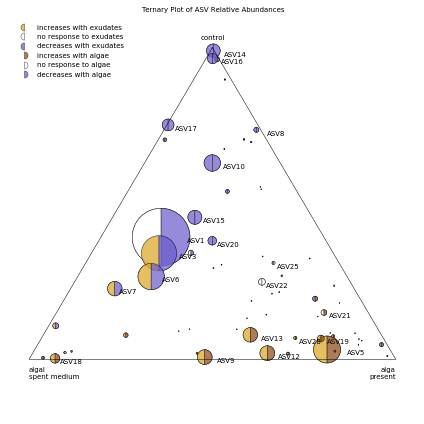

In [11]:
# DIFFERENTIAL ABUNDANCE TERNARY PLOT

# set up the plot
plt.figure(figsize=(6,6))

# fun math to set up the triangle axes
triangle_data = np.array([[0,0,1],[0,1,0],[1,0,0],[0,0,1]])
a=triangle_data[:,0]
b=triangle_data[:,1]
c=triangle_data[:,2]
x = 0.5 * ( 2.*b+c ) / ( a+b+c )
y = 0.5*np.sqrt(3) * c / (a+b+c)
plt.plot(x,y, color='k',lw=0.5, alpha=1)

# label the corners
plt.text(x[0],y[0]+0.02,'control',ha='center',va='bottom',fontsize=7, color='k')
plt.text(x[1],y[1]-0.02,'alga\npresent',ha='right',va='top',fontsize=7, color='k')
plt.text(x[2],y[2]-0.02,'algal\nspent medium',ha='left',va='top',fontsize=7, color='k')

# fun math to get the data in the right coordinates
Pfrac = data.loc[:,'Phaeodactylum']
Sfrac = data.loc[:,'Phaeodactylum spent medium']
Cfrac = data.loc[:,'none']
x2 = 0.5 * ( 2.*Pfrac+Cfrac ) / ( Cfrac+Pfrac+Sfrac )
y2 = 0.5*np.sqrt(3) * Cfrac / (Cfrac+Pfrac+Sfrac)

# ASV markers colot coded by significant differential abundance 
mycolorsA = ['slateblue' if data['PtoC'][i] and data['LFC.PtoC'][i] > 0
            else 'saddlebrown' if data['PtoC'][i] and data['LFC.PtoC'][i] < 0 
            else 'w' for i in range(len(data['LFC.PtoC']))]
mycolorsE = ['slateblue' if data['PStoC'][i] and  data['LFC.PStoC'][i] > 0 
            else 'goldenrod' if data['PStoC'][i] and data['LFC.PStoC'][i] < 0
            else 'w' for i in range(len(data['LFC.PtoC']))]
plt.scatter(x2,y2, c='w', edgecolor='k', marker=MarkerStyle('o'),
            s = 5000*Tdata.mean(),alpha=1, linewidths=0.5)
plt.scatter(x2,y2, c=mycolorsE, edgecolor='k', marker=MarkerStyle('o', fillstyle='left'),
            s = 5000*Tdata.mean(),alpha=0.7, linewidths=0.5)
plt.scatter(x2,y2, c=mycolorsA, edgecolor='k', marker=MarkerStyle('o', fillstyle='right'),
            s = 5000*Tdata.mean(),alpha=0.7, linewidths=0.5)

# Label ASVs > 0.5% abundance
for c in Tdata.columns[Tdata.mean()>0.005][1:]:
    Pfrac = data['Phaeodactylum'][c]
    Sfrac = data['Phaeodactylum spent medium'][c]
    Cfrac = data['none'][c]
    x3 = 0.5 * ( 2.*Pfrac+Cfrac ) / ( Cfrac+Pfrac+Sfrac )
    y3 = 0.5*np.sqrt(3) * Cfrac / (Cfrac+Pfrac+Sfrac)
    plt.text(x3+np.sqrt(Tdata.mean()[c])/7, y3,
             c, va='top',ha='left', fontsize=7)
    
# legend
plt.scatter(10,10,c='goldenrod',edgecolor='k', marker=MarkerStyle('o', fillstyle='left'), alpha=0.7, s=50,
            label='increases with exudates', linewidths=0.5)
plt.scatter(10,10,c='w',edgecolor='k', marker=MarkerStyle('o', fillstyle='left'), alpha=0.7,s=50,
            label='no response to exudates', linewidths=0.5)
plt.scatter(10,10,c='slateblue',edgecolor='k', marker=MarkerStyle('o', fillstyle='left'), alpha=0.7,s=50,
            label='decreases with exudates', linewidths=0.5)
plt.scatter(10,10,c='saddlebrown',edgecolor='k', marker=MarkerStyle('o', fillstyle='right'), alpha=0.7,s=50,
            label='increases with algae', linewidths=0.5)
plt.scatter(10,10,c='w',edgecolor='k', marker=MarkerStyle('o', fillstyle='right'), alpha=0.7,s=50,
            label='no response to algae', linewidths=0.5)
plt.scatter(10,10,c='slateblue',edgecolor='k', marker=MarkerStyle('o', fillstyle='right'), alpha=0.7,s=50,
            label='decreases with algae', linewidths=0.5)
plt.legend(loc='upper left', frameon=False, fontsize=7)

# final cleanup
plt.ylim(-0.15, 0.95)
plt.xlim(-0.05, 1.05)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('Ternary Plot of ASV Relative Abundances', fontsize=7)
plt.tight_layout()
plt.savefig('FigureS9.png', dpi=300)

plt.show()